# Stream Data from a .csv 

In [2]:
import sys
import os
import time
import matplotlib.pyplot as plt
# from scipy.signal import butter, filtfilt, lfilter
from scipy import signal
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

In [3]:
import sys
sys.path.append("..") # So that it can find the modules
# Assuming the other modules (brainflow_stream, filtering, segmentation, classification) are available
from modules.brainflow_stream import *
from modules.filtering import *
from modules.segmentation import *
from modules.classification import *
from modules.ssvep_stim import *

from modules.visualization import *

<frozen importlib._bootstrap>:219: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.0 (SDL 2.30.7, Python 3.8.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Setting variables:
board_id = BoardIds.CYTON_BOARD.value # BoardIds.SYNTHETIC_BOARD.value 
frequencies = [9.25, 11.25, 13.25, 15.25]
buttons = ['Right', 'Left', 'Up', 'Down']
button_pos = [0, 2, 3, 1]
display = 0
segment_duration = 3

# Static Variables - Probably don't need to touch :)
harmonics = 3 # np.arange(1, 4) # Generates the 1st, 2nd, & 3rd Harmonics
sampling_rate = BoardShim.get_sampling_rate(board_id)
n_samples = sampling_rate * segment_duration

In [5]:
import numpy as np
from sklearn.cross_decomposition import CCA

def generate_reference_signals(frequencies, harmonics, sample_rate, n_samples):
    """Generate sine/cosine reference signals for each frequency and harmonic."""
    t = np.arange(n_samples) / sample_rate
    reference_signals = {}
    
    for f in frequencies:
        ref = []
        for h in range(1, harmonics + 1):
            ref.append(np.sin(2 * np.pi * f * h * t))
            ref.append(np.cos(2 * np.pi * f * h * t))
        reference_signals[f] = np.array(ref)
    
    return reference_signals

def cca_ssvep(eeg_data, reference_signals):
    """Apply CCA to find the SSVEP frequency with highest correlation."""
    # Transpose eeg_data to have shape (n_samples, n_channels)
    eeg_data = eeg_data.T
    
    cca = CCA(n_components=1)
    max_corr = 0
    detected_freq = None
    
    for f, ref_signal in reference_signals.items():
        # Transpose the reference signal to (samples, harmonics * 2)
        ref_signal = ref_signal.T
        
        # Apply CCA between EEG data and reference signal
        cca.fit(eeg_data, ref_signal)
        U, V = cca.transform(eeg_data, ref_signal)
        corr = np.corrcoef(U.T, V.T)[0, 1]
        
        # Update max correlation and detected frequency
        if corr > max_corr:
            max_corr = corr
            detected_freq = f
    
    return detected_freq, max_corr


In [27]:
for array in reference_signals.keys():
    print(reference_signals[array].shape())
    # plot_eeg_time_series(reference_signals[array], sampling_rate=sampling_rate)

TypeError: 'tuple' object is not callable

In [5]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

filter_obj = Filtering(sampling_rate)

time.sleep(15)

while True:
    segment = board.get_current_board_data(num_samples=n_samples)
    eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels
            
    # Apply bandpass filter
    filtered_segment = filter_obj.bandpass_filter(eeg_segment, highcut=30, lowcut=5, order=4)
    
    # print(filtered_segment.shape)
    
    reference_signals = generate_reference_signals(frequencies=actual_freqs, 
                                                   harmonics=harmonics, 
                                                   sample_rate=sampling_rate, 
                                                   n_samples=n_samples)

    print(reference_signals.keys())
    
    # compare_eeg_time_series(eeg_segment, reference_signals)   

    detected_freq, correlation = cca_ssvep(eeg_data=filtered_segment, 
                                            reference_signals=reference_signals)
    
    print(f"Detected Frequency: {detected_freq} Hz with correlation: {correlation}")
    
    
    
    # Wait for the next segment of data
    time.sleep(segment_duration)

[Board 0, ] Board setup and streaming started successfully.
Actual Frequencies: [9.23, 11.43, 13.33, 15.0]
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 9.23 Hz with correlation: 0.4097655826115111
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 9.23 Hz with correlation: 0.45806070705944824
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 9.23 Hz with correlation: 0.40587999547811554
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 9.23 Hz with correlation: 0.4684154476745579
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 9.23 Hz with correlation: 0.3211106440725667
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 13.33 Hz with correlation: 0.4029278711058318
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 13.33 Hz with correlation: 0.44461685698618636
(8, 750)
dict_keys([9.23, 11.43, 13.33, 15.0])
Detected Frequency: 11.43 Hz with correlation: 0.34264678

KeyboardInterrupt: 

In [6]:
board.stop()

[Board 0, ] Streaming stopped.
[Board 0, ] Session released.


In [6]:
import numpy as np
import hashlib
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

filter_obj = Filtering(sampling_rate)

time.sleep(15)
# Initialize the previous segment hash and correlation threshold
previous_hash = None
correlation_threshold = 0.3  # Set based on your needs for a "significant" correlation

while True:
    # Get current segment and hash it to detect changes
    segment = board.get_current_board_data(num_samples=n_samples)
    current_hash = hashlib.md5(segment.tobytes()).hexdigest()

    if current_hash != previous_hash:
        # Only proceed if the segment is new
        previous_hash = current_hash
        eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels
        filtered_segment = filter_obj.bandpass_filter(eeg_segment, highcut=30, lowcut=5, order=4)
        
        filtered_segment = filtered_segment / np.max(np.abs(filtered_segment))
        
        reference_signals = generate_reference_signals(
            frequencies=actual_freqs, 
            harmonics=harmonics, 
            sample_rate=sampling_rate, 
            n_samples=n_samples
        )

        detected_freq, correlation = cca_ssvep(eeg_data=filtered_segment, reference_signals=reference_signals)
        
        # Apply thresholding to avoid low-correlation outputs
        if correlation > correlation_threshold:
            print(f"Detected Frequency: {detected_freq} Hz with correlation: {correlation}")
    else:
        print("No new data detected, skipping iteration.")

    # Wait for the next segment of data
    time.sleep(segment_duration)


[Board 0, ] Board setup and streaming started successfully.
Actual Frequencies: [9.23, 11.43, 13.33, 15.0]
Detected Frequency: 9.23 Hz with correlation: 0.40976558261151125
Detected Frequency: 9.23 Hz with correlation: 0.4580607070594481
Detected Frequency: 9.23 Hz with correlation: 0.4058799954781154
Detected Frequency: 9.23 Hz with correlation: 0.46841544767455784
Detected Frequency: 9.23 Hz with correlation: 0.32111064407256656
Detected Frequency: 13.33 Hz with correlation: 0.40292787110583184
Detected Frequency: 13.33 Hz with correlation: 0.4446168569861865
Detected Frequency: 11.43 Hz with correlation: 0.34264678289452166
Detected Frequency: 15.0 Hz with correlation: 0.3785099882947816
Detected Frequency: 9.23 Hz with correlation: 0.4165920738393242
Detected Frequency: 9.23 Hz with correlation: 0.3731627922139655
Detected Frequency: 13.33 Hz with correlation: 0.3519959299441388
Detected Frequency: 9.23 Hz with correlation: 0.3744314533736322
Detected Frequency: 9.23 Hz with correl

KeyboardInterrupt: 

In [1]:
board.stop()

NameError: name 'board' is not defined

# ALSO OLD

In [5]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

cca_classifier = SSVEPClassifier(frequencies=actual_freqs, 
                                win_len=segment_duration, 
                                s_rate=sampling_rate)

filter_obj = Filtering(sampling_rate)

time.sleep(15)

while True:
    segment = board.get_current_board_data(num_samples=n_samples)
    eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels
            
    # Apply bandpass filter
    filtered_segment = filter_obj.bandpass_filter(dc_offset_removed, highcut=30, lowcut=0.1, order=4)

    r = cca_classifier(filtered_segment) 
    print(r)
    
    # visualize_all_channels_plotly(eeg_segment, filtered_segment)
    
    # Check signal alignment for the first frequency
    # reference_signal = cca_classifier.reference_signals[0]  # First frequency reference
    # check_signal_alignment(filtered_segment, reference_signal)

    # Compare one EEG channel (Channel 1) against reference signal for the first frequency
    # visualize_reference_vs_eeg(filtered_segment, reference_signal, actual_freqs[0])
    
    

    # Perform classification using the filtered EEG data
    # correlations = []
    # for freq_idx, freq in enumerate(actual_freqs):
    #     detected_freq, correlation = cca_classifier(filtered_segment)
    #     correlations.append(correlation)
    #     print(f"Frequency: {freq} Hz, Correlation: {correlation}")

    # Plot correlation coefficients across frequencies (optional, uncomment if needed)
    # plot_correlation_across_frequencies(actual_freqs, correlations)
    


    # Wait for the next segment of data
    time.sleep(segment_duration)

[Board 1, ] Board setup and streaming started successfully.
Actual Frequencies: [9.23, 11.43, 13.33, 15.0]


TypeError: __init__() got an unexpected keyword argument 'win_len'

## OLDER CODE

In [4]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

# board.board_config('/2')

# Let data accumulate
time.sleep(15)

raw_data = board.get_current_board_data(num_samples = n_samples)
eeg_data = raw_data[1:9, :] # Removing the timestamp column
eeg_data.shape
board.stop()

[Board 0, ] Board setup and streaming started successfully.
[Board 0, ] Streaming stopped.
[Board 0, ] Session released.


In [5]:
timestamps = raw_data[22, :]
package_nums = raw_data[0]

In [6]:
filter_obj = Filtering(sampling_rate)

filtered_data = filter_obj.bandpass_filter(eeg_data, highcut=30, lowcut=5, order=8)

channel_names = board.get_eeg_names(board_id=board_id)

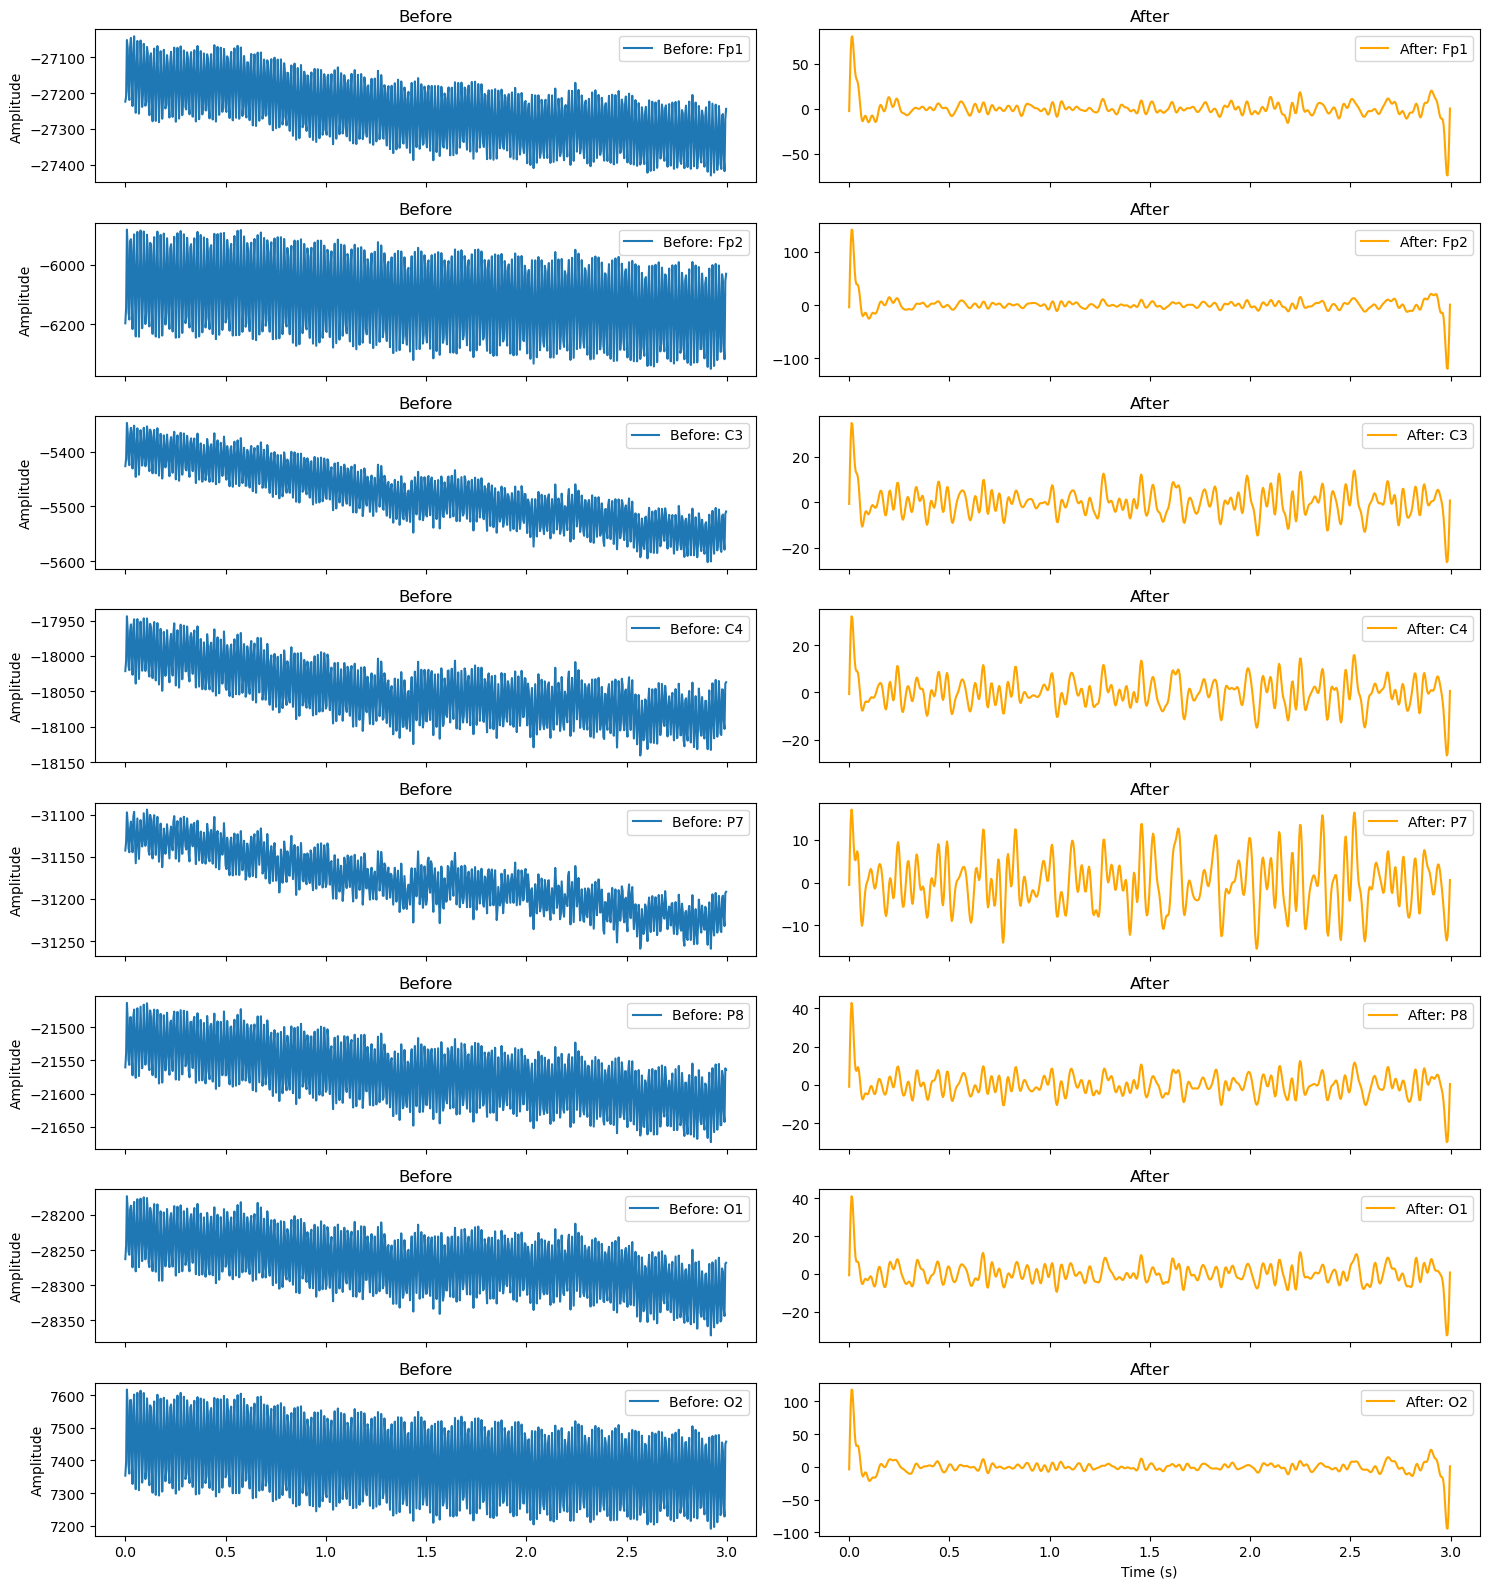

In [10]:
compare_eeg_time_series(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

c:\Users\surge\miniforge3\envs\stealthneuro\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 750, using nperseg = 750
  warnings.warn('nperseg = {0:d} is greater than input length '


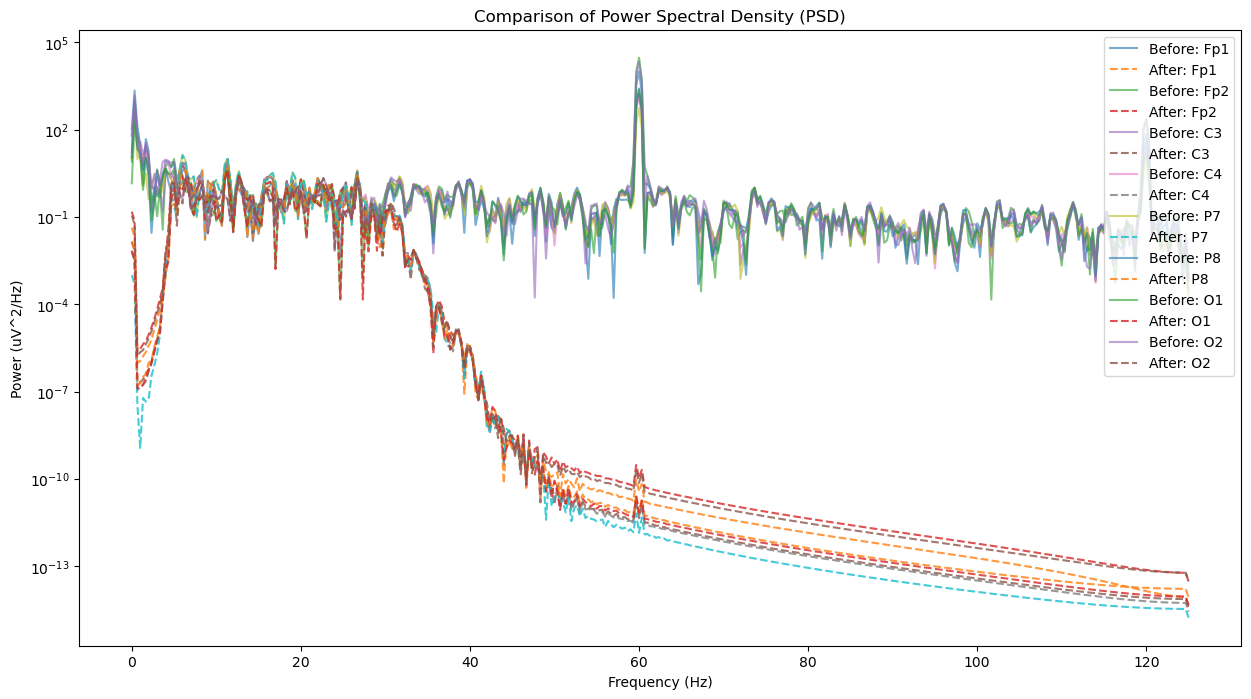

In [11]:
compare_psd(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

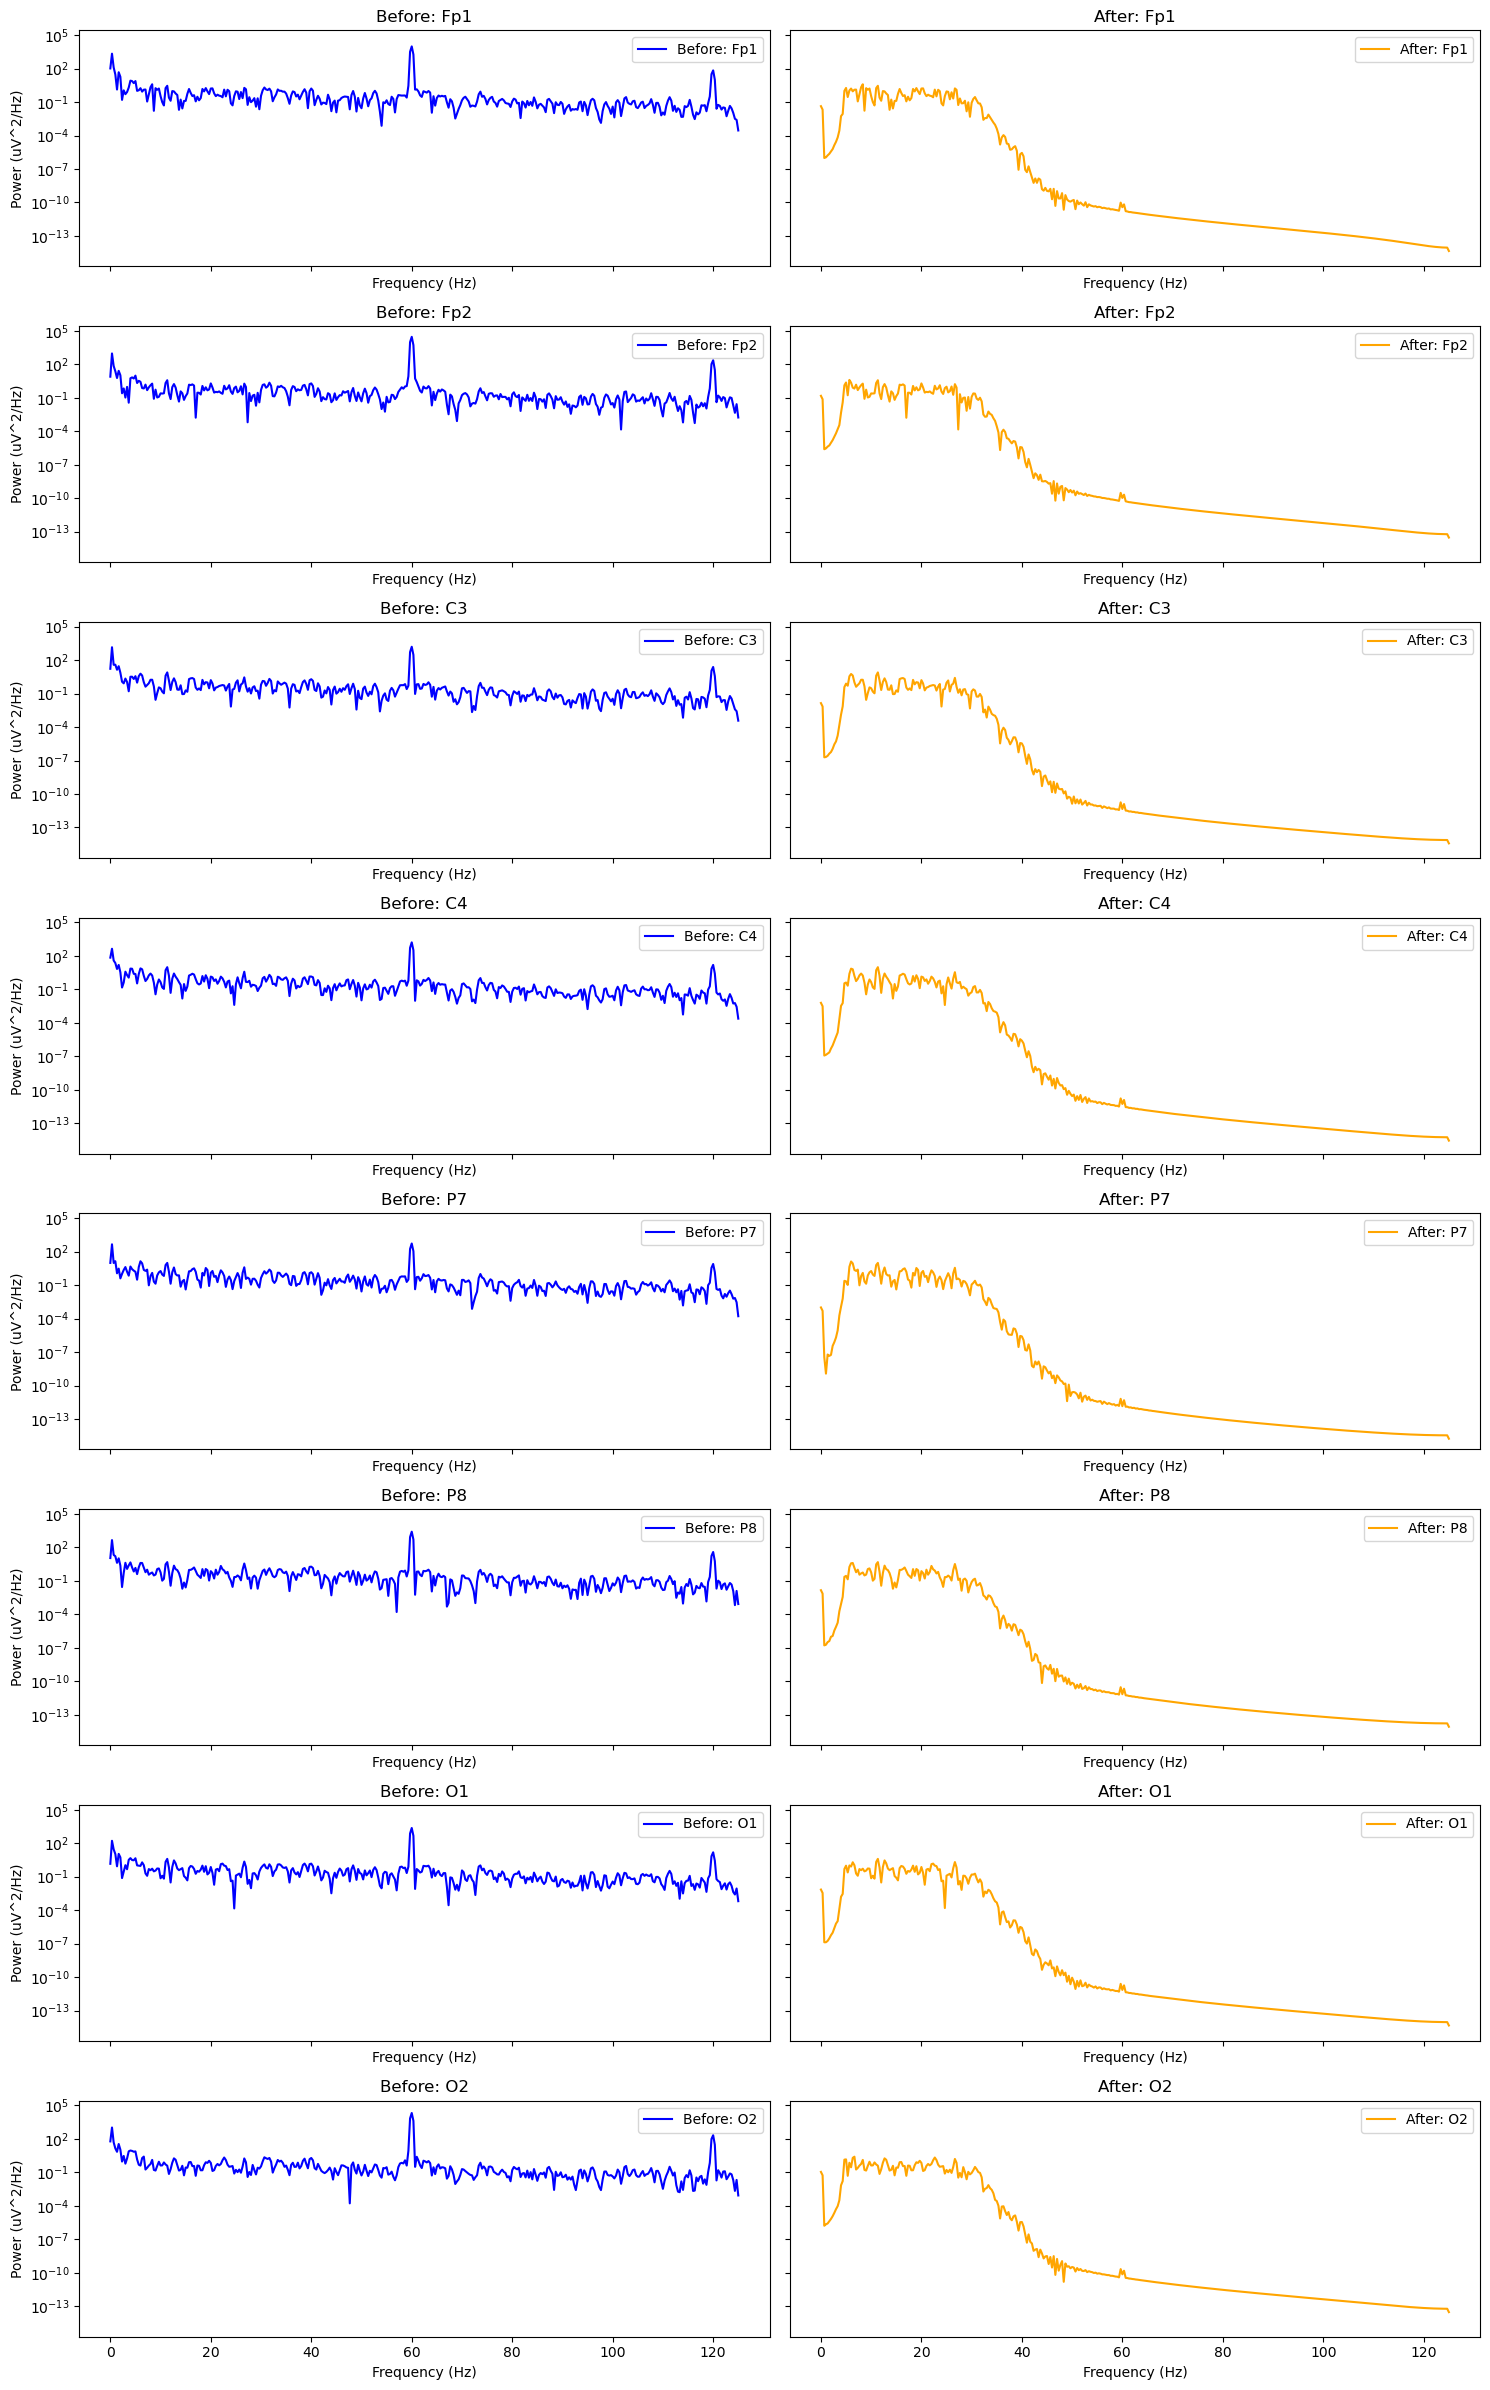

In [12]:
compare_psd_side_by_side(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

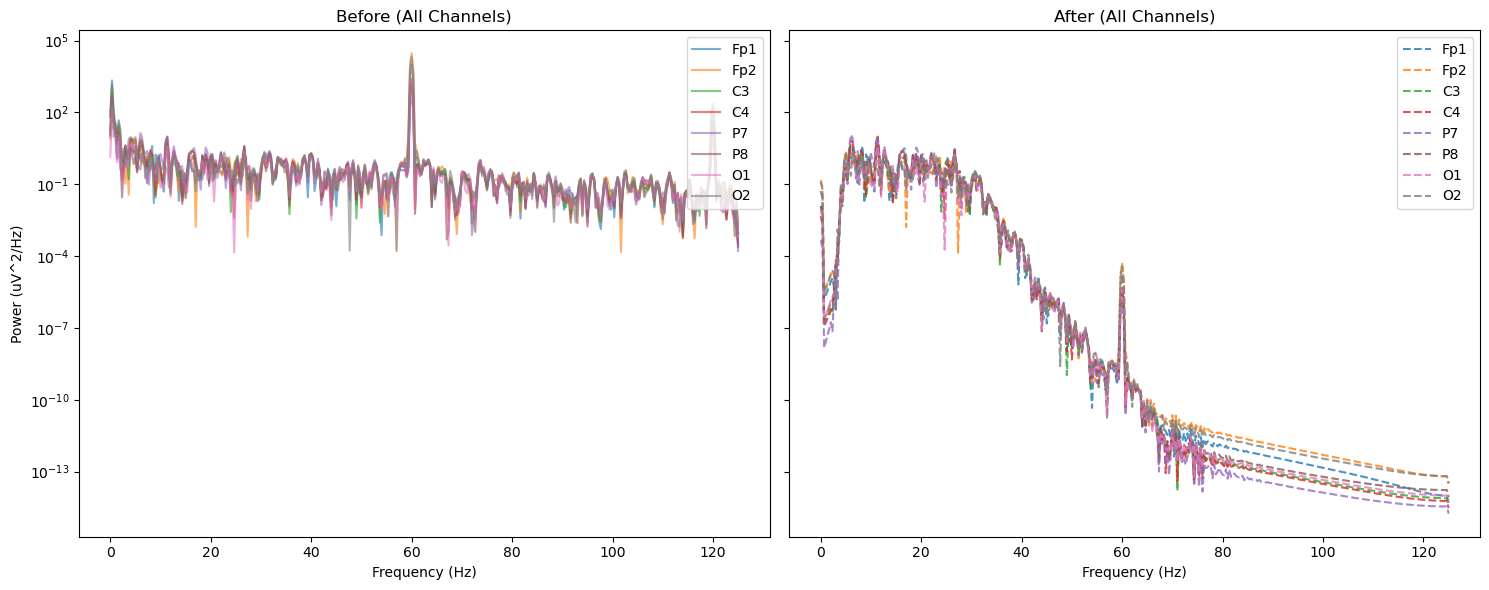

In [14]:
compare_psd_stacked(eeg_data, 
                    filtered_data, 
                    sampling_rate, 
                    channel_names = channel_names,
                    average=False)

c:\Users\surge\Documents\GitHub\BCItoolkit\testing\..\modules\visualization.py:295: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(channel_names, rotation=45, ha='right')
c:\Users\surge\Documents\GitHub\BCItoolkit\testing\..\modules\visualization.py:301: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(channel_names, rotation=45, ha='right')


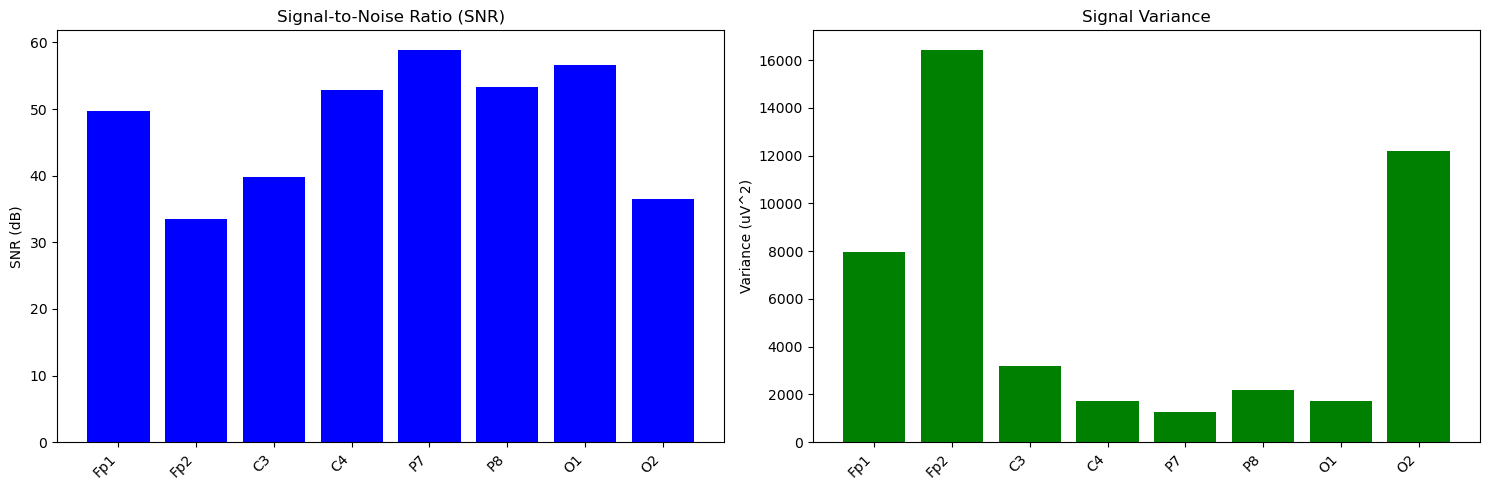

In [14]:
plot_signal_quality(eeg_data, channel_names = channel_names)

### Reference code from `Pipeline_Test_Suite_STREAM_DATA.py`